# Proyecto Final Computación Evolutiva

**Idea 3 : Usando computación evolutiva para asignación de ítems a bins**

El objetivo de este proyecto es implementar un algoritmo evolutivo para poder asignar ítems de diferentes tamaños a un conjunto de Bins. Cada Bin tendrá un tamaño máximo pre-especificado. La idea es que el algoritmo minimice la suma total del tamaño de los ítems que no pudieron ser asignados junto con la suma total de áreas no usadas en cada Bin.

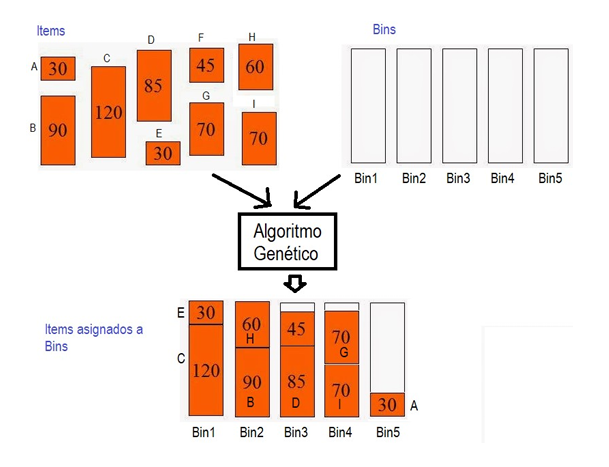

### Librerías a usar:

In [ ]:
import sys
import time
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt

In [ ]:
from random import randrange, sample

### Variables globales:

In [ ]:
NUM_BINS = 5          # numero de bins
NUM_ITEMS = 9         # numero de items
MAX_ITEM_SIZE = 120   # máximo tamaño posible de cada  item
MAX_BINS_SIZE = 150   # máximo tamaño posible de cada  bin
POP_SIZE = 10          # número de individuos

### Definimos las propiedades de nuestra clase Item:

In [ ]:
class Item(object):
    def __init__(self, size):
        self.size = size # Tamaño del item. Existe una restricción en el tamaño máximo por bin

### Definimos la clase Individuo en el AG con sus respectivos operadores:

In [ ]:
class Individual:

    def __init__(self, chromosome):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]
        self.fitness = -1.5  # -1.5 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]

    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2]

    def mutation_flip(self):
        "Cambia el alelo de un gen escogido aleatoriamente."
        new_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(0,len(new_chromosome))   # escoge un gen para mutar
        new_chromosome[mutGene] = random.randint(0,NUM_BINS)
        return Individual(new_chromosome)

    def mutation_multiflip(self):
        """
        Cambia los alelos de un conjunto de genes escogidos aleatoriamente (hasta un maximo de 50% de genes).
        """
        new_chromosome = deepcopy(self.chromosome)
        num_genes = len(new_chromosome)
        num_genes_to_change = random.randrange(1, num_genes // 2) # número de genes a cambiar (máximo la mitad)
        idx_genes_to_change = sample(range(num_genes), num_genes_to_change) # selección de indices de genes a cambiar

        for mutGene in idx_genes_to_change: # Cambio de genes de forma iterativa
            new_chromosome[mutGene] = random.randint(0,NUM_BINS)

        return Individual(new_chromosome)

### Probando el algoritmo de generación de items

In [ ]:
#pool de items generado aleatoriamente
ItemPool_Aleatorio = [Item(random.randint(1,MAX_ITEM_SIZE)) for x in range (0,NUM_ITEMS)]

#itemPool del problema específico:
ItemPool_Ejemplo = [Item(30), Item(90),Item(120),Item(85),Item(30),Item(45),Item(70),Item(60),Item(70)]

#itemPool creado a partir partir los bins en 3 pedazos:
ItemPool_Division=[]
for i in range(NUM_BINS):
  ItemPool_Division.append(Item(MAX_BINS_SIZE*0.1))
  ItemPool_Division.append(Item(MAX_BINS_SIZE*0.3))
  ItemPool_Division.append(Item(MAX_BINS_SIZE*0.6))

In [ ]:
#Mostrar pool creado
for i in ItemPool_Division:
  print(i.size)

15.0
45.0
90.0
15.0
45.0
90.0
15.0
45.0
90.0
15.0
45.0
90.0
15.0
45.0
90.0


### Método para inicializar una población:

In [ ]:
def init_population(popsize, chromosome_size, zeroes=False):
    """Inicializa una poblacion de popsize individuos, cada cromosoma de individuo de tamaño chromosome_size.
       Si zeroes==False La inicializacion es aleatoria (por defecto), si zeroes=True los cromosomas son vectores de ceros"""
    population = []
    for i in range(popsize):
        if zeroes:
            new_chromosome = [0 for j in range(chromosome_size)]  # vector de zeros de tamaño chromosome_size
        else:
            new_chromosome = [random.randint(0,NUM_BINS) for j in range(chromosome_size)]

        population.append( Individual(new_chromosome) )
    return population

### Probando el algoritmo de creación de población

In [ ]:
## Inicializa una poblacion inicial de forma aleatoria
poblacion_inicial =  init_population(POP_SIZE, NUM_ITEMS)

In [ ]:
#Mostrar a cada individuo de la población creada
for i in poblacion_inicial:
  print(i.chromosome)

[0, 1, 5, 3, 4, 2, 4, 5, 5]
[0, 4, 2, 5, 2, 4, 0, 3, 2]
[1, 1, 2, 3, 5, 5, 2, 5, 0]
[5, 2, 0, 1, 2, 5, 5, 2, 0]
[0, 5, 3, 4, 3, 0, 2, 5, 1]
[4, 0, 3, 1, 4, 5, 4, 1, 4]
[1, 4, 5, 2, 2, 0, 3, 4, 4]
[4, 5, 4, 1, 2, 2, 3, 3, 4]
[2, 3, 2, 0, 0, 1, 0, 2, 3]
[0, 1, 4, 1, 0, 4, 5, 4, 0]


### Método para obtener el Fitness:

In [ ]:
def get_fitness(chromosome, items):
    """Retorna el fitness del cromosoma pasado:
    + sumatoria del tamaño de items incluídos en bins (bin 1 al 5)
    - sumatoria del tamaño de ítems no incluídos en bins (bin 0)
    - sumatoria de espacio libre (no usado) de bins
    Si el tamaño de los ítems en el bin excede al tamaño del bin, resta 100 puntos por cada bin excedido"""
    fitness = 0 # initialize fitness to 0
    sum_size = np.zeros(NUM_BINS + 1)
    contador = 0
    area_vacia = 0

    for i, gen in enumerate(chromosome):
         sum_size[gen] += items[i].size

    fitness = sum_size[1:].sum() - sum_size[0]

    for size in sum_size[1:]:
      diferencia = MAX_BINS_SIZE - size
      if diferencia < 0:
        contador += 1
      else:
        area_vacia += diferencia

    fitness -= area_vacia

    if(contador > 0):
      fitness += -100 * contador

    return fitness

### Método para evaluar una población:

In [ ]:
def evaluate_population(population , items):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    popsize = len(population)
    for i in range(popsize):
        if population[i].fitness == -1.5:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = get_fitness(population[i].chromosome ,items)

### Operadores de seleccion de padres

#### Seleccion por Ruleta

In [ ]:
def select_parents_roulette(population):
    popsize = len(population)
    iParent1 = 0
    iParent2 = 0
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness:
            iParent1 = i
            break

    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre
        cumfitness += population[i].fitness
        if cumfitness > pickfitness:
            iParent2 = i
            break
    return (population[iParent1], population[iParent2])

#### Seleccion por Torneo

In [ ]:
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)

    iParent1=np.argmax(list_indiv)

    # Escoje el segundo padre, desconsiderando el primer padre
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)

    return (population[x1[iParent1]],population[x2[iParent2]])

### Operadores de Seleccion de sobrevivientes


In [ ]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        next_population.append(population[isurvivors[i]])
    return next_population

### Definimos el Algoritmo Genético para dar solución a nuestro problema:

In [ ]:
def genetic_algorithm(poblacion_inicial, items, ngen=100, pmut=0.1,
                      crossover="onepoint", mutation="flip",
                      selection_parents_method="roulette",
                      selection_survivors_method="ranking"):
    """Algoritmo Genetico para el problema de asignación de ítems a bins
        poblacion_inicial:  individuos creados inicialmente
        items:              pool de items a escoger para los bins
                            Debe ser una lista de objetos de clase Item con un tamaño específico.
        ngen:               máximo numero de generaciones
        pmut:               tasa de mutacion
        crossover:          operador de cruzamiento
        mutation:           operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes para la siguiente generación
    """

    population = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la inicial

    popsize = len(population)
    evaluate_population(population, items)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # fitness del mejor individuo
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))

    bestfit=0
    bestg=0
    for g in range(ngen):   # Por cada generacion

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
        mating_pool = []
        for i in range(int(popsize/2)):
            if selection_parents_method == "roulette":
                mating_pool.append(select_parents_roulette(population))
            elif selection_parents_method == "tournament":
                mating_pool.append(select_parents_tournament(population, 3))
            else:
                raise NotImplementedError
        ## Crea la poblacion descendencia cruzando las parejas del mating pool
        offspring_population = []
        for i in range(len(mating_pool)):
            if crossover == "onepoint":
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut:
                if mutation == "flip":
                    offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
                elif mutation == "multiflip":
                    offspring_population[i] = offspring_population[i].mutation_multiflip() # invierte N genes del cromosoma, donde N es menor o igual al 50% de la longitud del cromosoma
                else:
                    raise NotImplementedError

        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, items)   # evalua la poblacion descendencia

        ## Selecciona individuos para la sgte. generación
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)

        if (g % 5 == 0):  # muestra resultados cada 5 generaciones
            print("generacion {}, (Mejor fitness = {})".format(g, population[ibest[0]].fitness))

        ###1ra generación donde se encontró el mejor fitness
        if population[ibest[0]].fitness > bestfit:
          bestg = g
          bestfit = population[ibest[0]].fitness

    sum_bins = np.zeros(NUM_BINS + 1)
    for i, gen in enumerate((population[ibest[0]].chromosome)):
      sum_bins[gen] += items[i].size

    print("Mejor individuo en la ultima generacion = {} (fitness = {}), tamaño asignado en cada bin: {} ".format(population[ibest[0]].chromosome, population[ibest[0]].fitness,sum_bins))

    return population[ibest[0]], bestfitness, bestg  # devuelve el mejor individuo y la lista de mejores fitness x gen

### Probando los mejores hiperparámetors del AG

#### 1. Probando el algoritmo genético con los diferentes operadores de cruzamiento (onepoint vs uniform) y de selección (ruleta vs torneo) implementados (mutación deshabilitada).
Se consideró la distribución de ítems del ejemplo propuesto y 5 individuos para comparar si el algoritmo llega a una solución óptima de igual forma que en el ejemplo.

Nota: 450 es el fitness máximo para el problema planteado (600 - 0 - 150 = 450)

In [ ]:
## Hiperparámetros del algoritmo genetico
GENERATIONS = 100   # numero de generaciones
PMUT = 0            # tasa de mutacion
crossover=['onepoint','uniform']
mutation=['flip','multiflip']
selection_parents_method=['roulette','tournament']
selection_survivors_method=['ranking']

onepoint_ruleta_fmax=[]
onepoint_ruleta_gmax=[]
onepoint_torneo_fmax=[]
onepoint_torneo_gmax=[]
uniform_ruleta_fmax=[]
uniform_ruleta_gmax=[]
uniform_torneo_fmax=[]
uniform_torneo_gmax=[]

for i in range(10):
  poblacion_inicial_onepoint_ruleta =  init_population(POP_SIZE, NUM_ITEMS)
  poblacion_inicial_onepoint_torneo = poblacion_inicial_onepoint_ruleta
  poblacion_inicial_multipoint_ruleta = poblacion_inicial_onepoint_ruleta
  poblacion_inicial_multipoint_torneo = poblacion_inicial_onepoint_ruleta

  # método de cruzamiento onepoint y metodo de seleccion ruleta
  best_ind, best_fitness, bestg = genetic_algorithm(poblacion_inicial_onepoint_ruleta, ItemPool_Ejemplo, GENERATIONS, PMUT,crossover[0], mutation[0],selection_parents_method[0],selection_survivors_method[0])
  onepoint_ruleta_fmax.append(max(best_fitness))
  onepoint_ruleta_gmax.append(bestg)

  # método de cruzamiento onepoint y metodo de seleccion torneo
  best_ind, best_fitness, bestg = genetic_algorithm(poblacion_inicial_onepoint_torneo, ItemPool_Ejemplo, GENERATIONS, PMUT,crossover[0], mutation[0],selection_parents_method[1],selection_survivors_method[0])
  onepoint_torneo_fmax.append(max(best_fitness))
  onepoint_torneo_gmax.append(bestg)

  # método de cruzamiento uniform y metodo de seleccion ruleta
  best_ind, best_fitness, bestg = genetic_algorithm(poblacion_inicial_multipoint_ruleta, ItemPool_Ejemplo, GENERATIONS, PMUT,crossover[1], mutation[0],selection_parents_method[0],selection_survivors_method[0])
  uniform_ruleta_fmax.append(max(best_fitness))
  uniform_ruleta_gmax.append(bestg)

  # método de cruzamiento uniform y metodo de seleccion torneo
  best_ind, best_fitness, bestg = genetic_algorithm(poblacion_inicial_multipoint_torneo, ItemPool_Ejemplo, GENERATIONS, PMUT,crossover[1], mutation[0],selection_parents_method[1],selection_survivors_method[0])
  uniform_torneo_fmax.append(max(best_fitness))
  uniform_torneo_gmax.append(bestg)

print("Resultados")
print("Escenario 1: Cruzamiento onepoint y seleccion ruleta")
print(onepoint_ruleta_fmax)
print(onepoint_ruleta_gmax)
print("best fitness prom: ", np.mean(onepoint_ruleta_fmax), "gen. conv. prom.: ", np.mean(onepoint_ruleta_gmax))
print("Escenario 2: Cruzamiento onepoint y seleccion torneo")
print(onepoint_torneo_fmax)
print(onepoint_torneo_gmax)
print("best fitness prom: ", np.mean(onepoint_torneo_fmax), "gen. conv. prom.: ", np.mean(onepoint_torneo_gmax))
print("Escenario 3: Cruzamiento uniform y seleccion ruleta")
print(uniform_ruleta_fmax)
print(uniform_ruleta_gmax)
print("best fitness prom: ", np.mean(uniform_ruleta_fmax), "gen. conv. prom.: ", np.mean(uniform_ruleta_gmax))
print("Escenario 4: Cruzamiento uniform y seleccion torneo")
print(uniform_torneo_fmax)
print(uniform_torneo_gmax)
print("best fitness prom: ", np.mean(uniform_torneo_fmax), "gen. conv. prom.: ", np.mean(uniform_torneo_gmax))

Poblacion inicial, best_fitness = 170.0
generacion 0, (Mejor fitness = 170.0)
generacion 5, (Mejor fitness = 450.0)
generacion 10, (Mejor fitness = 450.0)
generacion 15, (Mejor fitness = 450.0)
generacion 20, (Mejor fitness = 450.0)
generacion 25, (Mejor fitness = 450.0)
generacion 30, (Mejor fitness = 450.0)
generacion 35, (Mejor fitness = 450.0)
generacion 40, (Mejor fitness = 450.0)
generacion 45, (Mejor fitness = 450.0)
generacion 50, (Mejor fitness = 450.0)
generacion 55, (Mejor fitness = 450.0)
generacion 60, (Mejor fitness = 450.0)
generacion 65, (Mejor fitness = 450.0)
generacion 70, (Mejor fitness = 450.0)
generacion 75, (Mejor fitness = 450.0)
generacion 80, (Mejor fitness = 450.0)
generacion 85, (Mejor fitness = 450.0)
generacion 90, (Mejor fitness = 450.0)
generacion 95, (Mejor fitness = 450.0)
Mejor individuo en la ultima generacion = [5, 3, 2, 1, 3, 1, 4, 4, 5] (fitness = 450.0), tamaño asignado en cada bin: [  0. 130. 120. 120. 130. 100.] 
Poblacion inicial, best_fitness

**Resultados:**

<table>
  <tr>
    <th>Cruzamiento</th>
    <th>Seleccion</th>
    <th>best fitness - prom.</th>
    <th>gen. converg. - prom.</th>
    </tr>
  <tr>
    <td>onepoint</td>
    <td>ruleta</td>
    <td>350.5</td>
    <td>2.9</td>
  </tr>
    </tr>
  <tr>
    <td>onepoint</td>
    <td>torneo</td>
    <td>323.0</td>
    <td>0.8</td>
  </tr>
    </tr>
  <tr>
    <td>uniform</td>
    <td>ruleta</td>
    <td>415.5</td>
    <td>3.0</td>
  </tr>
    </tr>
  <tr>
    <td>uniform</td>
    <td>torneo</td>
    <td>360.0</td>
    <td>1.2</td>
  </tr>
</table>

**Conclusión:**

Se elige al operador de cruzamiento "uniform" y el metodo de selección "ruleta"

#### 2. Probando operadores de mutación "flip" y "multiflip" con el operador de cruzamiento "uniform", método de selección "ruleta" y PMUT 0.2, 0.5 y 0.8

Nota: 450 es el fitness máximo para el problema planteado (600 - 0 - 150 = 450)

In [ ]:
## Hiperparámetros del algoritmo genetico
GENERATIONS = 100   # numero de generaciones
PMUT = 0            # tasa de mutacion
crossover=['onepoint','uniform']
mutation=['flip','multiflip']
selection_parents_method=['roulette','tournament']
selection_survivors_method=['ranking']

flip2_fmax=[]
flip2_gmax=[]
flip5_fmax=[]
flip5_gmax=[]
flip8_fmax=[]
flip8_gmax=[]
multiflip2_fmax=[]
multiflip2_gmax=[]
multiflip5_fmax=[]
multiflip5_gmax=[]
multiflip8_fmax=[]
multiflip8_gmax=[]

for i in range(10):
  poblacion_inicial_flip_02 =  init_population(POP_SIZE, NUM_ITEMS)
  poblacion_inicial_flip_05 = poblacion_inicial_flip_02
  poblacion_inicial_flip_08 = poblacion_inicial_flip_02
  poblacion_inicial_multiflip_02 = poblacion_inicial_flip_02
  poblacion_inicial_multiflip_05 = poblacion_inicial_flip_02
  poblacion_inicial_multiflip_08 = poblacion_inicial_flip_02

  # cruzamiento uniform, mutación flip, PMUT 0.2
  best_ind, best_fitness, bestg = genetic_algorithm(poblacion_inicial_flip_02, ItemPool_Ejemplo, GENERATIONS, 0.2,crossover[1], mutation[0],selection_parents_method[0],selection_survivors_method[0])
  flip2_fmax.append(max(best_fitness))
  flip2_gmax.append(bestg)

  # cruzamiento uniform, mutación flip, PMUT 0.5
  best_ind, best_fitness, bestg = genetic_algorithm(poblacion_inicial_flip_05, ItemPool_Ejemplo, GENERATIONS, 0.5,crossover[1], mutation[0],selection_parents_method[0],selection_survivors_method[0])
  flip5_fmax.append(max(best_fitness))
  flip5_gmax.append(bestg)

  # cruzamiento uniform, mutación flip, PMUT 0.8
  best_ind, best_fitness, bestg = genetic_algorithm(poblacion_inicial_flip_08, ItemPool_Ejemplo, GENERATIONS, 0.8,crossover[1], mutation[0],selection_parents_method[0],selection_survivors_method[0])
  flip8_fmax.append(max(best_fitness))
  flip8_gmax.append(bestg)

  # cruzamiento uniform, mutación multiflip, PMUT 0.2
  best_ind, best_fitness, bestg = genetic_algorithm(poblacion_inicial_multiflip_02, ItemPool_Ejemplo, GENERATIONS, 0.2,crossover[1], mutation[1],selection_parents_method[0],selection_survivors_method[0])
  multiflip2_fmax.append(max(best_fitness))
  multiflip2_gmax.append(bestg)

  # cruzamiento uniform, mutación multiflip, PMUT 0.5
  best_ind, best_fitness, bestg = genetic_algorithm(poblacion_inicial_multiflip_05, ItemPool_Ejemplo, GENERATIONS, 0.5,crossover[1], mutation[1],selection_parents_method[0],selection_survivors_method[0])
  multiflip5_fmax.append(max(best_fitness))
  multiflip5_gmax.append(bestg)

  # cruzamiento uniform, mutación multiflip, PMUT 0.8
  best_ind, best_fitness, bestg = genetic_algorithm(poblacion_inicial_multiflip_08, ItemPool_Ejemplo, GENERATIONS, 0.8,crossover[1], mutation[1],selection_parents_method[0],selection_survivors_method[0])
  multiflip8_fmax.append(max(best_fitness))
  multiflip8_gmax.append(bestg)


print("flip, PMUT 0.2 - best fitness prom: ", np.mean(flip2_fmax), "gen. conv. prom.: ", np.mean(flip2_gmax))
print("flip, PMUT 0.5 - best fitness prom: ", np.mean(flip5_fmax), "gen. conv. prom.: ", np.mean(flip5_gmax))
print("flip, PMUT 0.8 - best fitness prom: ", np.mean(flip8_fmax), "gen. conv. prom.: ", np.mean(flip8_gmax))
print("multiflip, PMUT 0.2 - best fitness prom: ", np.mean(multiflip2_fmax), "gen. conv. prom.: ", np.mean(multiflip2_gmax))
print("multiflip, PMUT 0.5 - best fitness prom: ", np.mean(multiflip5_fmax), "gen. conv. prom.: ", np.mean(multiflip5_gmax))
print("multiflip, PMUT 0.8 - best fitness prom: ", np.mean(multiflip8_fmax), "gen. conv. prom.: ", np.mean(multiflip8_gmax))

Poblacion inicial, best_fitness = 140.0
generacion 0, (Mejor fitness = 160.0)
generacion 5, (Mejor fitness = 450.0)
generacion 10, (Mejor fitness = 450.0)
generacion 15, (Mejor fitness = 450.0)
generacion 20, (Mejor fitness = 450.0)
generacion 25, (Mejor fitness = 450.0)
generacion 30, (Mejor fitness = 450.0)
generacion 35, (Mejor fitness = 450.0)
generacion 40, (Mejor fitness = 450.0)
generacion 45, (Mejor fitness = 450.0)
generacion 50, (Mejor fitness = 450.0)
generacion 55, (Mejor fitness = 450.0)
generacion 60, (Mejor fitness = 450.0)
generacion 65, (Mejor fitness = 450.0)
generacion 70, (Mejor fitness = 450.0)
generacion 75, (Mejor fitness = 450.0)
generacion 80, (Mejor fitness = 450.0)
generacion 85, (Mejor fitness = 450.0)
generacion 90, (Mejor fitness = 450.0)
generacion 95, (Mejor fitness = 450.0)
Mejor individuo en la ultima generacion = [3, 2, 3, 5, 4, 5, 4, 1, 1] (fitness = 450.0), tamaño asignado en cada bin: [  0. 130.  90. 150. 100. 130.] 
Poblacion inicial, best_fitness

**Resultados:**
<table>
  <tr>
    <th>Cruzamiento</th>
    <th>Mutación</th>
    <th>tasa mutación</th>
    <th>best fitness - prom.</th>
    <th>gen. converg. - prom.</th>
  <tr>
    <td>Uniform</td>
    <td>flip</td>
    <td>0.2</td>
    <td>439.5</td>
    <td>10.0</td>
  <tr>
    <td>Uniform</td>
    <td>flip</td>
    <td>0.5</td>
    <td>450.0</td>
    <td>5.7</td>
  <tr>
    <td>Uniform</td>
    <td>flip</td>
    <td>0.8</td>
    <td>450.0</td>
    <td>6.4</td>
  <tr>
    <td>Uniform</td>
    <td>multiflip</td>
    <td>0.2</td>
    <td>450.0</td>
    <td>8.0</td>
  <tr>
    <td>Uniform</td>
    <td>multiflip</td>
    <td>0.5</td>
    <td>450.0</td>
    <td>8.4</td>
  <tr>
    <td>Uniform</td>
    <td>multiflip</td>
    <td>0.8</td>
    <td>450.0</td>
    <td>4.4</td>
  </tr>
</table>

**Conclusión:**

Se elige el operador de mutación multiflip y PMUT 0.8

#### 3. Probando el algoritmo con un ItemPool generado a partir de dividir los bins en n pedazos.
En este caso, el fitness máximo a obtener es de 750 (150*5 -0 -0)

Se consideró los mejores operadores identificados en los pasos anteriores: crossover "uniform", selección "ruleta", mutación "multiflip" y pmut 0.8.



Poblacion inicial, best_fitness = 350.0
generacion 0, (Mejor fitness = 415.0)
generacion 5, (Mejor fitness = 575.0)
generacion 10, (Mejor fitness = 705.0)
generacion 15, (Mejor fitness = 705.0)
generacion 20, (Mejor fitness = 705.0)
generacion 25, (Mejor fitness = 705.0)
generacion 30, (Mejor fitness = 705.0)
generacion 35, (Mejor fitness = 705.0)
generacion 40, (Mejor fitness = 705.0)
generacion 45, (Mejor fitness = 750.0)
generacion 50, (Mejor fitness = 750.0)
generacion 55, (Mejor fitness = 750.0)
generacion 60, (Mejor fitness = 750.0)
generacion 65, (Mejor fitness = 750.0)
generacion 70, (Mejor fitness = 750.0)
generacion 75, (Mejor fitness = 750.0)
generacion 80, (Mejor fitness = 750.0)
generacion 85, (Mejor fitness = 750.0)
generacion 90, (Mejor fitness = 750.0)
generacion 95, (Mejor fitness = 750.0)
Mejor individuo en la ultima generacion = [4, 3, 4, 1, 5, 2, 2, 4, 5, 5, 1, 1, 3, 2, 3] (fitness = 750.0), tamaño asignado en cada bin: [  0. 150. 150. 150. 150. 150.] 


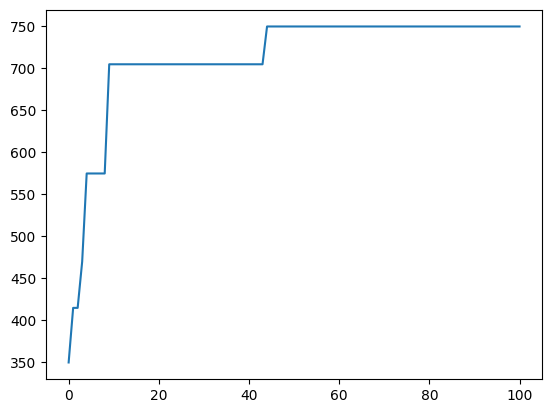

In [ ]:
## Hiperparámetros del algoritmo genetico
GENERATIONS = 100   # numero de generaciones
PMUT = 0.8          # tasa de mutacion
crossover=['onepoint','uniform']
mutation=['flip','multiflip']
selection_parents_method=['roulette','tournament']
selection_survivors_method=['ranking']

#inicializar población
poblacion_inicial =  init_population(POP_SIZE, len(ItemPool_Division))

# Evaluando la población
best_ind, bestfitness,bestg = genetic_algorithm(poblacion_inicial, ItemPool_Division, GENERATIONS, PMUT,
                                          crossover[1], mutation[1],
                                          selection_parents_method[0],
                                          selection_survivors_method[0])

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()

**Conclusión**
Se observa que el algoritmo reconstruye perfectamente todos los bins, ordenando los ítems de tal forma que sumen 150 en cada bin